Laura VERCHERE  
Liam HUISSOUD  
Classe : 3D


**TP2**

In [ ]:
!pip install transformers

In [ ]:
!pip install torch

In [74]:
!pip install xgboost

In [75]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import recall_score, precision_score, accuracy_score,  f1_score
import torch
import transformers as transf
import warnings
warnings.filterwarnings('ignore')

In [5]:
df = pd.read_csv('/content/email.csv')

In [6]:
df.head()

,Category,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


## Nettoyage du dataset

Nous avons nettoyé les données : categorie 1 pour mail ok et 0 pour spam + suppression ligne dont la categorie est Nan (non renseignée)



In [8]:
df['Category'] = df['Category'].map({'ham': 1, 'spam': 0})
df = df.dropna(subset=['Category'])
print(df)

      Category                                            Message
0          1.0  Go until jurong point, crazy.. Available only ...
1          1.0                      Ok lar... Joking wif u oni...
2          0.0  Free entry in 2 a wkly comp to win FA Cup fina...
3          1.0  U dun say so early hor... U c already then say...
4          1.0  Nah I don't think he goes to usf, he lives aro...
...        ...                                                ...
5567       0.0  This is the 2nd time we have tried 2 contact u...
5568       1.0               Will ü b going to esplanade fr home?
5569       1.0  Pity, * was in mood for that. So...any other s...
5570       1.0  The guy did some bitching but I acted like i'd...
5571       1.0                         Rofl. Its true to its name

[5572 rows x 2 columns]


In [13]:
df['Category'].head()

,Category
0,1.0
1,1.0
2,0.0
3,1.0
4,1.0


In [14]:
df['Category'].value_counts()

,count
Category,
1.0,4825
0.0,747


On constate qu'on a trop de mail correct (qui ne sont pas des spams) par rapport au nombres de spam. Il faut donc qu'on réduise le nombre de mails bons.

In [19]:
df_categorie_1 = df[df['Category'] == 1]
df_to_remove = df_categorie_1.sample(3000)
df = df.drop(df_to_remove.index)

In [20]:
df['Category'].value_counts()

,count
Category,
1.0,825
0.0,747


## Chargement du modèle BERT

In [23]:
model_class, tokenizer_c, weights_pretrained = (transf.DistilBertModel, transf.DistilBertTokenizer, 'distilbert-base-uncased')

tokenizer = tokenizer_c.from_pretrained(weights_pretrained)
model = model_class.from_pretrained(weights_pretrained)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

## Préparation du texte

In [24]:
example = df.head(5)["Message"].values[3]

In [25]:
print(tokenizer.encode(example, add_special_tokens = True))

[101, 3453, 999, 999, 2004, 1037, 11126, 2897, 8013, 2017, 2031, 2042, 3479, 2000, 4374, 2050, 1069, 21057, 2692, 3396, 10377, 999, 2000, 4366, 2655, 5641, 2692, 2575, 16576, 24096, 21472, 2487, 1012, 4366, 3642, 1047, 2140, 22022, 2487, 1012, 9398, 2260, 2847, 2069, 1012, 102]


In [27]:
tokenized = df["Message"].apply((lambda x : tokenizer.encode(x, add_special_tokens=True)))

In [28]:
tokenized

,Message
2,"[101, 2489, 4443, 1999, 1016, 1037, 1059, 2243..."
3,"[101, 1057, 24654, 2360, 2061, 2220, 7570, 209..."
5,"[101, 2489, 5244, 2290, 4931, 2045, 9548, 2009..."
8,"[101, 3453, 999, 999, 2004, 1037, 11126, 2897,..."
9,"[101, 2018, 2115, 4684, 2340, 2706, 2030, 2062..."
...,...
5565,"[101, 9616, 1061, 26947, 1012, 1012, 1012, 102]"
5566,"[101, 14764, 2013, 1051, 2475, 1024, 2000, 213..."
5567,"[101, 2023, 2003, 1996, 3416, 2051, 2057, 2031..."
5569,"[101, 12063, 1010, 1008, 2001, 1999, 6888, 200..."


In [29]:
max_len = 0
for i in tokenized.values :
  if len(i) > max_len :
    max_len = len(i)

max_len

125

In [30]:
tokenized_zerroes = np.array([i + [0]*(max_len-len(i)) for i in tokenized.values])
np.array(tokenized_zerroes).shape

(1572, 125)

In [31]:
attention_mask = np.where(tokenized_zerroes != 0, 1, 0)
attention_mask

array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0]])

In [32]:
attention_mask.shape

(1572, 125)

In [33]:
input_ids = torch.tensor(tokenized_zerroes)
attention_mask = torch.tensor(attention_mask)

In [34]:
input_ids

tensor([[  101,  2489,  4443,  ...,     0,     0,     0],
        [  101,  1057, 24654,  ...,     0,     0,     0],
        [  101,  2489,  5244,  ...,     0,     0,     0],
        ...,
        [  101,  2023,  2003,  ...,     0,     0,     0],
        [  101, 12063,  1010,  ...,     0,     0,     0],
        [  101,  1996,  3124,  ...,     0,     0,     0]])

In [35]:
with torch.no_grad():
  last_hidden_states = model(input_ids, attention_mask=attention_mask)

In [38]:
features = last_hidden_states[0][:,0,:]

In [39]:
features.shape

torch.Size([1572, 768])

In [40]:
labels = df["Category"]

### Modele : Train Test

On définie les ensembles test et train sur lesquels on va appliquer les modèles : Logistic Regresion, Random Forest et XGBoost

In [41]:
train_features, test_features, train_labels, test_labels = train_test_split(features, labels)

Pour rappel, nous avions un score de 0.8840125391849529 avec LSTM.

### Logistic regression

On initialise le modèle Logistic Regression



In [42]:
lr_clf = LogisticRegression()
lr_clf.fit(train_features, train_labels)

LogisticRegression()

On calcule le score sur l'ensemble train.

In [54]:
lr_clf.score(train_features, train_labels)

0.9974554707379135

On calcule le score sur l'ensemble de test.

In [43]:
lr_clf.score(test_features, test_labels)

0.9770992366412213

Création de la matrice de confusion pour la Logistic Regression



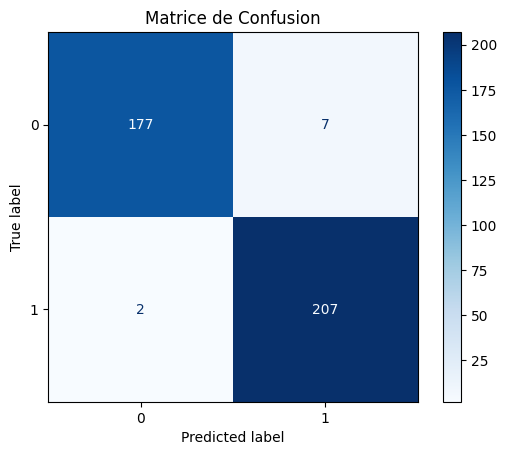

In [68]:
# Prédictions sur l'ensemble de test
lr_test_predictions = lr_clf.predict(test_features)

# Génération de la matrice de confusion
cm = confusion_matrix(test_labels, lr_test_predictions)

# Affichage de la matrice de confusion
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title("Matrice de Confusion")
plt.show()

### Random Forest

On initialise le modèle Random Forest.

In [85]:
rf_clf = RandomForestClassifier()
rf_clf.fit(train_features, train_labels)

RandomForestClassifier()

On calcule le score sur l'ensemble train.

In [86]:
rf_clf.score(train_features, train_labels)

1.0

On calcule le score sur l'ensemble test.

In [87]:
rf_clf.score(test_features, test_labels)

0.9669211195928753

Création de la matrice de confusion pour le Random Forest



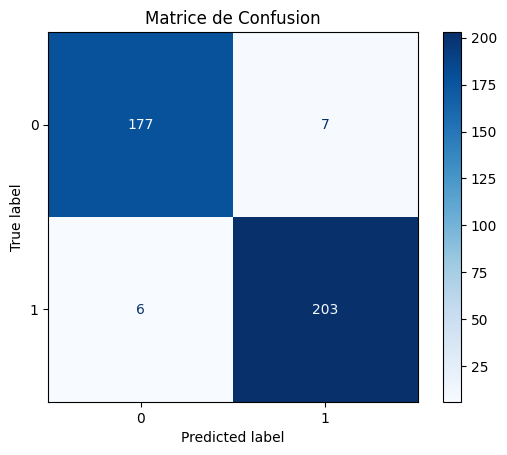

In [88]:
# Prédictions sur l'ensemble de test
rf_test_predictions = rf_clf.predict(test_features)

# Génération de la matrice de confusion
cm = confusion_matrix(test_labels, rf_test_predictions)

# Affichage de la matrice de confusion
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title("Matrice de Confusion")
plt.show()

### XGBoost

On initialise le modèle XGBoost.

In [76]:
xgb_clf = XGBClassifier()
xgb_clf.fit(train_features, train_labels)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

On calcule le score sur l'ensemble train.

In [77]:
xgb_clf.score(train_features, train_labels)

1.0

On calcule le score sur l'ensemble test

In [78]:
xgb_clf.score(test_features, test_labels)

0.9720101781170484

Création de la matrice de confusion pour le XGBoost


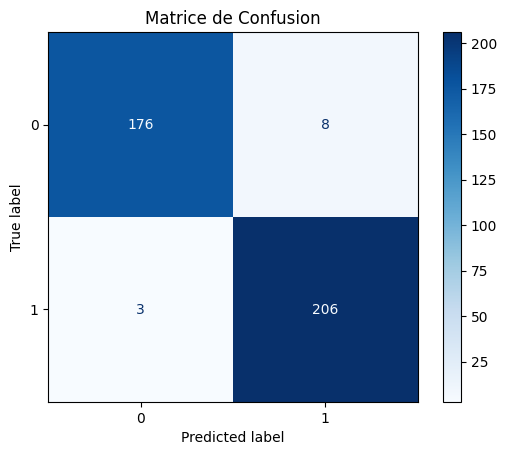

In [82]:
# Prédictions sur l'ensemble de test
xgb_test_predictions = xgb_clf.predict(test_features)

# Génération de la matrice de confusion
cm = confusion_matrix(test_labels, xgb_test_predictions)

# Affichage de la matrice de confusion
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title("Matrice de Confusion")
plt.show()

## Comparaison des modèles - Courbes ROC

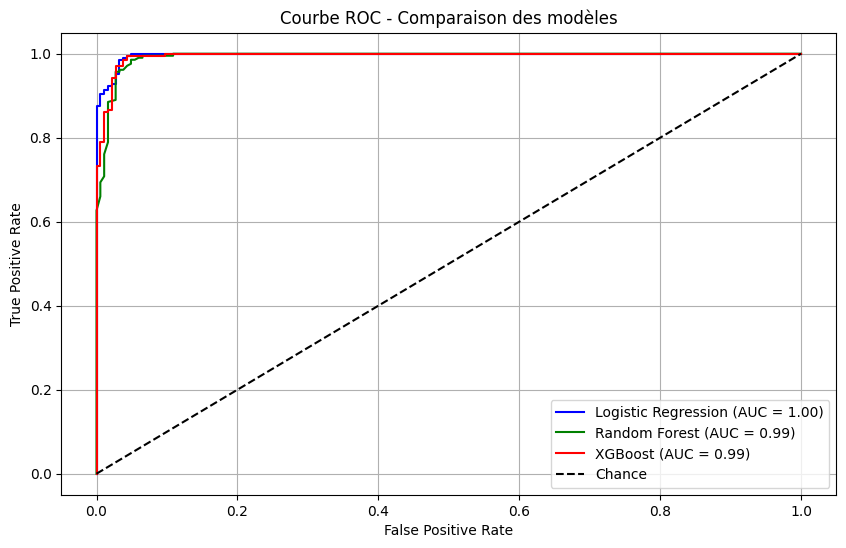

In [79]:
# Prédiction des probabilités pour chaque modèle
logistic_probs = lr_clf.predict_proba(test_features)[:, 1]  # Probabilités pour la classe positive
rf_probs = rf_clf.predict_proba(test_features)[:, 1]  # Probabilités pour la classe positive
xgb_probs = xgb_clf.predict_proba(test_features)[:, 1]      # Probabilités pour la classe positive

# Calcul des courbes ROC et des valeurs AUC pour chaque modèle
logistic_fpr, logistic_tpr, _ = roc_curve(test_labels, logistic_probs)
rf_fpr, rf_tpr, _ = roc_curve(test_labels, rf_probs)
xgb_fpr, xgb_tpr, _ = roc_curve(test_labels, xgb_probs)
logistic_auc = auc(logistic_fpr, logistic_tpr)
rf_auc = auc(rf_fpr, rf_tpr)
xgb_auc = auc(xgb_fpr, xgb_tpr)

# Affichage des courbes ROC
plt.figure(figsize=(10, 6))
plt.plot(logistic_fpr, logistic_tpr, label=f"Logistic Regression (AUC = {logistic_auc:.2f})", color="blue")
plt.plot(rf_fpr, rf_tpr, label=f"Random Forest (AUC = {rf_auc:.2f})", color="green")
plt.plot(xgb_fpr, xgb_tpr, label=f"XGBoost (AUC = {xgb_auc:.2f})", color="red")
plt.plot([0, 1], [0, 1], 'k--', label="Chance")  # Ligne de référence aléatoire
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Courbe ROC - Comparaison des modèles")
plt.legend(loc="lower right")
plt.grid()
plt.show()

## Comparaison des modèles - Métriques

In [83]:
# Calcul des métriques pour chaque modèle
metrics = {
    "Modèle": ["Logistic Regression", "Random Forest", "XGBoost"],
    "Recall": [
        recall_score(test_labels, lr_test_predictions),
        recall_score(test_labels, rf_test_predictions),
        recall_score(test_labels, xgb_test_predictions)
    ],
    "Precision": [
        precision_score(test_labels, lr_test_predictions),
        precision_score(test_labels, rf_test_predictions),
        precision_score(test_labels, xgb_test_predictions)
    ],
    "Accuracy": [
        accuracy_score(test_labels, lr_test_predictions),
        accuracy_score(test_labels, rf_test_predictions),
        accuracy_score(test_labels, xgb_test_predictions)
    ],
    "F1 Score": [
        f1_score(test_labels, lr_test_predictions),
        f1_score(test_labels, rf_test_predictions),
        f1_score(test_labels, xgb_test_predictions)
    ]
}


# Création d'un DataFrame pour afficher les résultats
metrics_df = pd.DataFrame(metrics)
print(metrics_df)

                Modèle    Recall  Precision  Accuracy  F1 Score
0  Logistic Regression  0.990431   0.967290  0.977099  0.978723
1        Random Forest  0.985646   0.958140  0.969466  0.971698
2              XGBoost  0.985646   0.962617  0.972010  0.973995


## Conclusion  
D'après la matrice de confusion et le tableau précédent, la **Logisitic Regression** est le modèle le plus performant pour prédire la catégorie des spams dans les mails.